## I am using LUNA16 competition dataset

Lung cancer is the leading cause of cancer-related death worldwide. Screening high risk individuals for lung cancer with low-dose CT scans is now being implemented in the United States and other countries are expected to follow soon. In CT lung cancer screening, many millions of CT scans will have to be analyzed, which is an enormous burden for radiologists. Therefore there is a lot of interest to develop computer algorithms to optimize screening.?

The upcoming high-profile?Coding4Cancer?challenge invites coders to create the best computer algorithm that can identify a person as having lung cancer based on one or multiple low-dose CT images.

To be able to solve the Coding4Cancer challenge, and detect lung cancer in an early stage, pulmonary nodules, the early manifestation of lung cancers, have to be located. Many Computer-aided detection (CAD) systems have already been proposed for this task. The LUNA16 challenge will focus on a large-scale evaluation of automatic nodule detection algorithms on the publicly available LIDC/IDRI dataset.

## Things to do!
### Monday
1. .mhd files (extract 3D image data) - done

### Tuesday
2. Extract 2D image slice based on the coordinates?
3. Preprocess data


### Day after + Thursday
4. Train a CNN
5. Validate using their evaluation
6. Uncertainty quantification

Please let that interview happen.

In [83]:
2428/(2428+15660.0)

0.13423264042459088

### Import necessary libraries

In [6]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import os
import glob

import SimpleITK as sitk

from PIL import Image

%matplotlib inline
from IPython.display import clear_output
pd.options.mode.chained_assignment = None

### Let us import annotations

In [7]:
annotations = pd.read_csv('../src/data/annotations.csv')
candidates = pd.read_csv('../src/data/candidates.csv')

In [8]:
candidates.head()

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-56.08,-67.85,-311.92,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,53.21,-244.41,-245.17,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.66,-121.80,-286.62,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-33.66,-72.75,-308.41,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-32.25,-85.36,-362.51,0


### Candidates have two classes, one with nodules, one without

In [9]:
candidates.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 551065 entries, 0 to 551064
Data columns (total 5 columns):
seriesuid    551065 non-null object
coordX       551065 non-null float64
coordY       551065 non-null float64
coordZ       551065 non-null float64
class        551065 non-null int64
dtypes: float64(3), int64(1), object(1)
memory usage: 21.0+ MB


In [10]:
print len(candidates[candidates['class'] == 1])
print len(candidates[candidates['class'] == 0])

1351
549714


### Classes are heaviliy unbalanced, hardly 0.2% percent are positive.

The best way to move forward will be to undersample the negative class and then augment the positive class heaviliy to balance out the samples.

#### Plan of attack:

1. Get an initial subsample of negative class and keep all of the positives such that we have a 80/20 class distribution

2. Create a training set such that we augment minority class heavilby rotating to get a 50/50 class distribution

In [84]:
len(X_train)

6484

In [12]:
class CTScan(object):
    def __init__(self, filename = None, coords = None):
        self.filename = filename
        self.coords = coords
        self.ds = None
        self.image = None

    def reset_coords(self, coords):
        self.coords = coords

    def read_mhd_image(self):
        path = glob.glob('../data/raw/*/'+ self.filename + '.mhd')
        self.ds = sitk.ReadImage(path[0])
        self.image = sitk.GetArrayFromImage(self.ds)

    def get_resolution(self):
        return self.ds.GetSpacing()

    def get_origin(self):
        return self.ds.GetOrigin()

    def get_ds(self):
        return self.ds

    def get_voxel_coords(self):
        origin = self.get_origin()
        resolution = self.get_resolution()
        voxel_coords = [np.absolute(self.coords[j]-origin[j])/resolution[j] \
            for j in range(len(self.coords))]
        return tuple(voxel_coords)
    
    def get_image(self):
        return self.image
    
    def get_subimage(self, width):
        self.read_mhd_image()
        x, y, z = self.get_voxel_coords()
        subImage = self.image[z, y-width/2:y+width/2, x-width/2:x+width/2]
        return subImage   
    
    def normalizePlanes(self, npzarray):
        maxHU = 400.
        minHU = -1000.
        npzarray = (npzarray - minHU) / (maxHU - minHU)
        npzarray[npzarray>1] = 1.
        npzarray[npzarray<0] = 0.
        return npzarray
    
    def save_image(self, filename, width):
        image = self.get_subimage(width)
        image = self.normalizePlanes(image)
        Image.fromarray(image*255).convert('L').save(filename)
        

In [13]:
positives = candidates[candidates['class']==1].index  
negatives = candidates[candidates['class']==0].index

###  Check if my class works

In [14]:
scan = CTScan(np.asarray(candidates.iloc[negatives[600]])[0], \
              np.asarray(candidates.iloc[negatives[600]])[1:-1])
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

/Users/nemo/anaconda/envs/kaggleShit/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


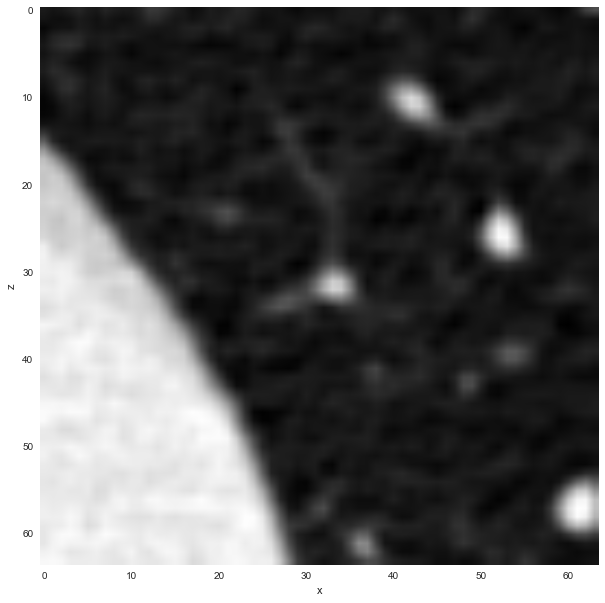

In [15]:
plt.figure(figsize = (10,10))
plt.imshow(image[z,y-65/2:y+65/2,x-65/2:x+65/2], cmap = 'gray')
#plt.scatter(x, y)
plt.grid('off')
plt.ylabel('z')
plt.xlabel('x')

### Try it on a test set you know works

In [16]:
filename = '1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793540579077826395208'
coords = (70.19, -140.93, 877.68)#[877.68, -140.93, 70.19]
scan = CTScan(filename, coords)
scan.read_mhd_image()
x, y, z = scan.get_voxel_coords()
image = scan.get_image()
dx, dy, dz = scan.get_resolution()
x0, y0, z0 = scan.get_origin()

/Users/nemo/anaconda/envs/kaggleShit/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


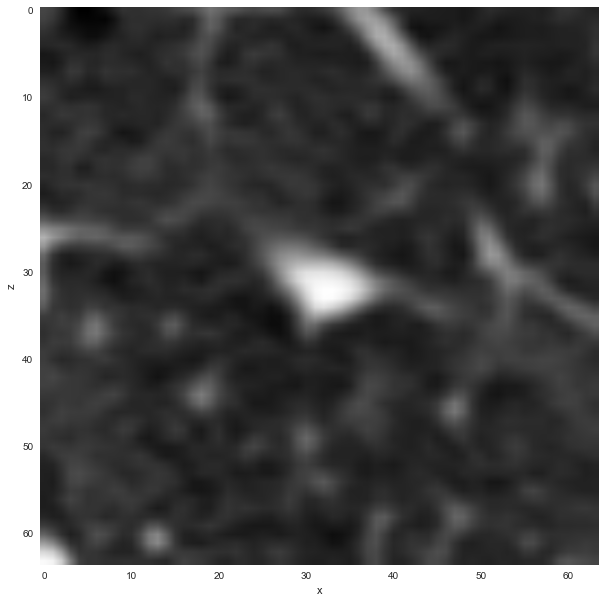

In [17]:
plt.figure(figsize = (10,10))
plt.imshow(image[z,y-65/2:y+65/2,x-65/2:x+65/2], cmap = 'gray')
#plt.scatter(x, y)
plt.grid('off')
plt.ylabel('z')
plt.xlabel('x')

###  Ok the class to get image data works

Next thing to do is to undersample negative class drastically. Since the number of positives in the data set of 551065 are 1351 and rest are negatives, I plan to make the dataset less skewed. Like a 70%/30% split.

In [18]:
positives

Int64Index([    13,     78,   1303,   3050,   3052,   3080,   3223,   3285,
              3287,   3289,
            ...
            545928, 546205, 546372, 546400, 547498, 548674, 550171, 550334,
            550810, 550906],
           dtype='int64', length=1351)

In [ ]:

len(np.random.choice(negatives, len(positives)*5))/(len(positives)*5+1351.0)

In [ ]:
1351.0/(len(positives)*5+1351.0)

In [19]:
np.random.seed(42)
negIndexes = np.random.choice(negatives, len(positives)*5, replace = False)

In [20]:
candidatesDf = candidates.iloc[list(positives)+list(negIndexes)]

In [21]:
candidatesDf[candidatesDf['class']==1].sum()

seriesuid    1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...
coordX                                                 -1773.5
coordY                                                 13756.4
coordZ                                                 -216466
class                                                     1351
dtype: object

### Now split it into test train set 

In [22]:
from sklearn.cross_validation import train_test_split
X = candidatesDf.iloc[:,:-1]
y = candidatesDf.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

In [128]:
X_train.to_pickle('traindata')
X_test.to_pickle('testdata')

### Now  extract data and save images to test and train folders

In [23]:
def normalizePlanes(npzarray):
    maxHU = 400.
    minHU = -1000.
    npzarray = (npzarray - minHU) / (maxHU - minHU)
    npzarray[npzarray>1] = 1.
    npzarray[npzarray<0] = 0.
    return npzarray

In [26]:
scan = CTScan(np.asarray(X_train.loc[trainIndexes[0]])[0], \
              np.asarray(X_train.loc[trainIndexes[0]])[1:])
image = scan.get_subimage(65)
image = normalizePlanes(image)
#plt.imshow(image, cmap = 'gray')
outputDir = '../src/data/train/'
#plt.scatter(x, y)
#plt.grid('off')
#plt.ylabel('z')
#plt.xlabel('x')
Image.fromarray(image*255).convert('L').save(os.path.join(outputDir, 'image_'  +  str(trainIndexes[0])+ '.tiff'))

/Users/nemo/anaconda/envs/kaggleShit/lib/python2.7/site-packages/ipykernel/__main__.py:37: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


### Focus on training data

In [31]:
print 'number of positive cases are ' + str(y_train.sum())
print 'total set size is ' + str(len(y_train))
print 'percentage of positive cases are ' + str(y_train.sum()*1.0/len(y_train))

number of positive cases are 1069
total set size is 6484
percentage of positive cases are 0.164867365824


### There are 1069 positive cases out of 6484 cases in the training set. We will need to augment the positive dataset like mad. 

### Augment training positive data (flip images/rotate them)

In [86]:
import pickle
augIndexes = X_train[y_train == 1].index
with open('posfile', 'wb') as fp:
    pickle.dump(augIndexes, fp)

In [125]:
augIndexes[4]

98986

In [82]:
from scipy.ndimage import rotate, imread
idx = 350312
dirName = '../src/data/train/'
inp = imread(dirName + 'image_'+ str(idx) + '.tiff')

# Rotate by 90
inp90 = rotate(inp, 90, reshape = False)
Image.fromarray(inp90).convert('L').save(dirName +\
                                         'image_' +\
                                         str(idx+1000000) + '.tiff')


### Add new keys to X_train and y_train for augmented data

In [109]:
tempDf = X_train[y_train == 1]
tempDf = tempDf.set_index(X_train[y_train == 1].index + 1000000)
X_train_new = X_train.append(tempDf)
ytemp = y_train.reindex(X_train[y_train == 1].index + 1000000)
y_train_new = y_train.append(ytemp)
print len(X_train_new), len(y_train_new)


7553 7553


### Preprocessing

In [123]:
from scipy.misc import imresize
class PreProcessing(object):
    def __init__(self, image = None):
        self.image = image
    
    def subtract_mean(self):
        return self.image - 0.25
    
    def downsample_data(self):
        self.image = imresize(self.image, size = (40, 40), interp='bilinear', mode='L')
        return self.image

In [127]:
plt.figure(figsize = (10,10))
inp = imread(dirName + 'image_'+ str(98986) + '.tiff')
plt.subplot(121)
plt.imshow(inp)
plt.grid(False)
Pp = PreProcessing(inp)
inp2 = Pp.downsample_data()
plt.subplot(122)
plt.imshow(inp2)
plt.grid(False)

SyntaxError: invalid syntax (<ipython-input-127-b17f98cfbd50>, line 5)

### Convnet training

In [ ]:
import tensorflow as tf

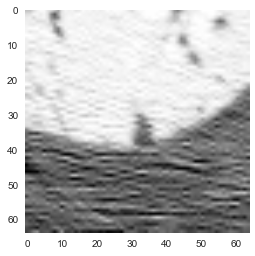

In [58]:
src_im = Image.open("../src/data/train/image_350312.tiff")
a = src_im.rotate(0)
plt.imshow(a)
plt.grid('off')

In [51]:
a.shape

AttributeError: shape

In [ ]:
src_im = Image.open("../src/data/train/images_154329.tiff")
angle = 45
size = 100, 100

dst_im = Image.new("RGBA", (196,283), "blue" )
im = src_im.convert('RGBA')
rot = im.rotate( angle, expand=1 ).resize(size)
dst_im.paste( rot, (50, 50), rot )
dst_im.save("test.png")

In [42]:
from joblib import Parallel, delayed

ImportError: No module named joblib

In [89]:
import multiprocessing
num_cores = multiprocessing.cpu_count()
print num_cores

4


In [ ]:
ids = list(set(candidates.seriesuid))
count = 0
for id1 in ids:
    clear_output()
    count += 1
    print count
    filename = glob.glob('./*/'+ id1 + '.mhd')
    ds = sitk.ReadImage(filename[0])
    image = sitk.GetArrayFromImage(ds)
    z0, y0, x0 = np.array(list(reversed(ds.GetOrigin())))
    dz, dy, dx = np.array(list(reversed(ds.GetSpacing())))
    indexes = candidates[candidates.seriesuid == id1].index
    candidates.iloc[indexes,5] = \
    np.abs(candidates.iloc[indexes,1]-x0)/dx
    candidates.iloc[indexes,6] = \
    np.abs(candidates.iloc[indexes,2]-y0)/dy
    candidates.iloc[indexes,7] = \
    np.abs(candidates.iloc[indexes,3]-z0)/dz

In [ ]:
import pickle
#candidates.to_pickle('candidates')

In [ ]:
candidates = pd.read_pickle('candidates')

### check if the registration is good

In [ ]:
len(candidates[candidates['class'] == 1])

In [ ]:
candidates[candidates['class'] == 1].seriesuid

### check images

In [ ]:
df = candidates[candidates.index == 1]
filename = glob.glob('./*/'+ df.seriesuid.iloc[0] + '.mhd')[0]
ds = sitk.ReadImage(filename)
image = sitk.GetArrayFromImage(ds)
image[df.voxelZ,:,:]

In [ ]:
df

In [ ]:
plt.figure(figsize = (10,10))
plt.imshow(image[:,df.voxelY,:], cmap = 'gray')
plt.scatter(df.voxelX, df.voxelZ)
plt.grid('off')
plt.ylabel('z')
plt.xlabel('x')

In [ ]:
plt.figure(figsize = (5,5))
width = 100
plt.imshow(image[df.voxelZ, df.voxelY-width/2:df.voxelY+width/2,\
                 df.voxelX-width/2:df.voxelX+width/2], cmap = 'gray')
#plt.scatter(df.voxelY-width/2, df.voxelX-width/2)
plt.grid('off')
plt.ylabel('y')
plt.xlabel('x')

In [ ]:
np.absolute(candidates[candidates.seriesuid == id1].coordX)

In [ ]:
len(configfiles)

### Read Images

In [ ]:
filepath = './subset0/'
paths = [path for path in os.listdir(filepath) if path.endswith('.mhd')]

In [ ]:
ds = sitk.ReadImage(filepath + paths[0])
image = sitk.GetArrayFromImage(ds)
image.shape

#### convert axes to coordinates    

In [ ]:
def get_coordinates(ds):
    image = sitk.GetArrayFromImage(ds)
    z0, y0, x0 = np.array(list(reversed(ds.GetOrigin())))
    dz, dy, dx = np.array(list(reversed(ds.GetSpacing())))
    
    z = np.array(range(image.shape[0]))*dz + z0
    y = np.array(range(image.shape[1]))*dy + y0
    x = np.array(range(image.shape[2]))*dx + x0
    return x, y, z

In [ ]:
candidates.head()

In [ ]:
plt.imshow(image[0,:,:], cmap = 'gray', extent = [min(y), max(y), min(x), max(x)])
plt.grid('off')
plt.ylabel('y')
plt.xlabel('x')

In [ ]:
indexes = candidates[candidates.seriesuid.str.contains(paths[0][:-4])].coordZ.sort_values().index

In [ ]:
candidates.iloc[indexes]

In [ ]:
len(candidates)

In [ ]:
len(annotations)

In [ ]:
annotations.head()

In [ ]:
def get_voxel_coordinates(ds):
    image = sitk.GetArrayFromImage(ds)
    z0, y0, x0 = np.array(list(reversed(ds.GetOrigin())))
    dz, dy, dx = np.array(list(reversed(ds.GetSpacing())))
    
    z = np.array(range(image.shape[0]))*dz + z0
    y = np.array(range(image.shape[1]))*dy + y0
    x = np.array(range(image.shape[2]))*dx + x0
    return x, y, z

In [ ]:
len(annotations)

In [ ]:
annotations.head()

In [ ]:
len(candidates[candidates['class']==1])*1.0/len(candidates)

In [ ]:
candidates[candidates['class']==0]

In [ ]:
a=ds.GetSpacing()

In [ ]:
b=ds.GetOrigin()

In [ ]:
a[0]-b[0]

In [ ]:
tuple([a[j]-b[j] for j in range(len(a))])